### Exploratory Analysis

The main idea is to apply some quantitative trading to the Crypto-sphere and to see if we can create some trading strategies with decent $\alpha$. In the future, it may be possible to run the mutual fund using both algorithmic trading and manual trading (via. Will's domain knowledge).

In order to start algorithmically trading, we need to first decide which currencies that we are willing to trade. We will also need to create a market index to use as the baseline for measuring how well a strategy is actually performing. 


#### Data Collection and Compression

Data is collected from the CoinMarketCap API. 


In [13]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

N_COINS = 30

df = pd.read_json(f'https://api.coinmarketcap.com/v1/ticker/?limit={N_COINS}')
df = df.infer_objects()
df.head(10)


,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,7982860000,16829450,bitcoin,1517055866,186116887550,2.100000e+07,Bitcoin,-1.00,3.92,-13.27,1.000000,11059.000000,1,BTC,16829450
1,2995630000,97241313,ethereum,1517055852,103596033236,NaN,Ethereum,-0.17,4.48,-5.89,0.096974,1065.350000,2,ETH,97241313
2,1206530000,38739142811,ripple,1517055841,46348672633,1.000000e+11,Ripple,-0.46,0.42,-24.23,0.000109,1.196430,3,XRP,99993093880
3,453246000,16934538,bitcoin-cash,1517055857,26706273674,2.100000e+07,Bitcoin Cash,-1.11,3.55,-17.10,0.143550,1577.030000,4,BCH,16934538
4,631236000,25927070538,cardano,1517055859,15601070228,4.500000e+10,Cardano,-0.62,3.93,-13.67,0.000055,0.601729,5,ADA,31112483745
5,493381000,17868055883,stellar,1517055843,11070743668,NaN,Stellar,-0.32,7.61,17.95,0.000056,0.619583,6,XLM,103629819514
6,316366000,54944008,litecoin,1517055841,9693551582,8.400000e+07,Litecoin,-0.44,3.20,-14.12,0.016059,176.426000,7,LTC,54944008
7,1021610000,631116954,eos,1517055855,8906259337,1.000000e+09,EOS,-0.92,4.38,1.63,0.001285,14.111900,8,EOS,900000000
8,258869000,65000000,neo,1517055850,8836880000,NaN,NEO,-0.06,4.73,-7.03,0.012375,135.952000,9,NEO,100000000
9,110000000,8999999999,nem,1517055846,7633988999,NaN,NEM,-0.17,7.06,-26.55,0.000077,0.848221,10,XEM,8999999999


We we want to compress this data by removing irrelevant and/or redundant features. This will allow us to minimize our disk usage (which will be useful for future scalability), and allow us to present our information in a more useful and human-readable format.

1. Remove ```name``` and ```id```. Instead, use ```symbol```.
2. Remove ```max_supply```, ```total_supply```, and ```available_supply```. The max supply of BTC will always be ```2.1e7```. We don't need to store it again every 5 minutes. Total and available supply are both irrelvant.
3. Remove ```price_btc```. It is a redundant field that can be easily re-calculated with ```price_usd```.
4. Reorder remaining fields to a more human-readable format.

This is my proposed improvement:

In [12]:
df = pd.read_json(f'https://api.coinmarketcap.com/v1/ticker/?limit={N_COINS}')
df = df.infer_objects()

df = df[['rank', 'symbol', 'price_usd', 'market_cap_usd', '24h_volume_usd',
         'percent_change_1h', 'percent_change_24h', 'percent_change_7d']]

df.head(10)

,rank,symbol,price_usd,market_cap_usd,24h_volume_usd,percent_change_1h,percent_change_24h,percent_change_7d
0,1,BTC,11059.000000,186116887550,7982860000,-1.00,3.92,-13.27
1,2,ETH,1065.350000,103596033236,2995630000,-0.17,4.48,-5.89
2,3,XRP,1.196430,46348672633,1206530000,-0.46,0.42,-24.23
3,4,BCH,1577.030000,26706273674,453246000,-1.11,3.55,-17.10
4,5,ADA,0.601729,15601070228,631236000,-0.62,3.93,-13.67
5,6,XLM,0.619583,11070743668,493381000,-0.32,7.61,17.95
6,7,LTC,176.426000,9693551582,316366000,-0.44,3.20,-14.12
7,8,EOS,14.111900,8906259337,1021610000,-0.92,4.38,1.63
8,9,NEO,135.952000,8836880000,258869000,-0.06,4.73,-7.03
9,10,XEM,0.848221,7633988999,110000000,-0.17,7.06,-26.55


We will make serial calls to this API every 5 minutes, and store results in their own time-stamped CSV.

###### Global Data

The API also provides access to global data.

In [10]:
json = requests.get('https://api.coinmarketcap.com/v1/global/').json()
gdf = pd.DataFrame([json]).infer_objects()

gdf.head()

,active_assets,active_currencies,active_markets,bitcoin_percentage_of_market_cap,last_updated,total_24h_volume_usd,total_market_cap_usd
0,567,896,8165,34.48,1517054667,2.336337e+10,5.386655e+11


I threw out ```last_updated``` and ```bitcoin_percentage_of_market_cap```, and re-ordered the remaining fields.

In [11]:
gdf = gdf[['total_market_cap_usd', 'total_24h_volume_usd', 
           'active_markets', 'active_currencies', 'active_assets']]

gdf.head()

,total_market_cap_usd,total_24h_volume_usd,active_markets,active_currencies,active_assets
0,5.386655e+11,2.336337e+10,8165,896,567


Since we would only be adding one line of data with each API call, data compression is not as much of an issue for this data. 

We will make serial calls to this API every 5 minutes, and save each record's data into its own row separated by date. The timestamp of the call will be saved as an additional field.

#### Establishing a Market Index

From [Investopedia](https://www.investopedia.com/terms/m/marketindex.asp#ixzz555QvCO80):

> A market index is an aggregate value produced by combining several stocks or other investment vehicles together and expressing their total values against a base value from a specific date. Market indexes are intended to represent an entire stock market and thus track the market's changes over time. 

We will choose coins for the index scaled by their respective market caps; this approach allows us to get a good measurement for the coin markets while keeping the total number of coins in our portfolio small.

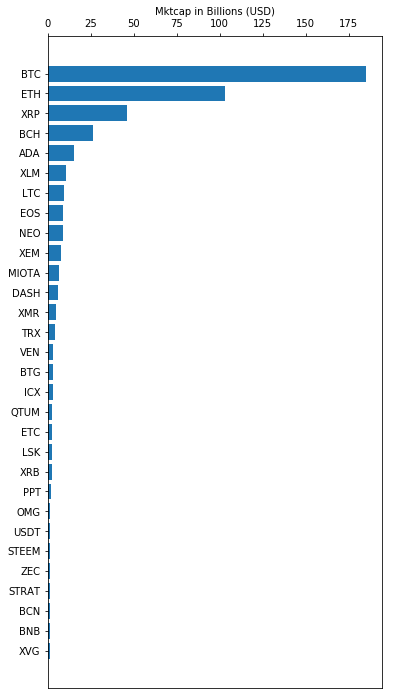

In [4]:
fig, ax = plt.subplots(figsize=(6, 12))

ax.barh(df['rank'], df['market_cap_usd']/10**9)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_xlabel('Mktcap in Billions (USD)')
plt.setp(ax, yticks=np.arange(1, N_COINS+1), yticklabels=df['symbol'])

#ax.set_xticklabels(df["symbol"])

plt.show()


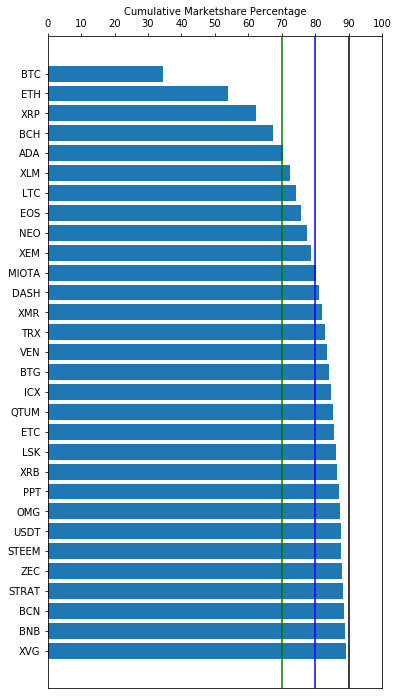

0     34.551476
1     53.783455
2     62.387806
3     67.345664
4     70.241909
5     72.297126
6     74.096675
7     75.750068
8     77.390582
9     78.807785
10    80.042813
11    81.156737
12    82.067779
13    82.890707
14    83.490274
15    84.043566
Name: market_cap_usd, dtype: float64


In [16]:
total_mkt_cap = gdf['total_market_cap_usd'][0]

fig, ax = plt.subplots(figsize=(6, 12))
ax.barh(df['rank'], 100*df['market_cap_usd'].cumsum()/total_mkt_cap)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_xlabel('Cumulative Marketshare Percentage')
plt.setp(ax, yticks=np.arange(1, N_COINS+1), yticklabels=df['symbol'])

plt.axvline(x=70, color="green")
plt.axvline(x=80, color="blue")
plt.axvline(x=90, color="black")
plt.xticks(np.arange(0, 101, 10))

plt.show()

mktcap_cumsum = 100*df['market_cap_usd'].cumsum()/total_mkt_cap
print(mktcap_cumsum[:16])

By adjusting the `N_COINS` variable, we can see that the top 100 coins makes up approximately 95% of the market cap, while the top 5, 10, and 35 make up 70%, 80%, and 90% respectively. 


In [7]:
def top_n_perc(n):
    """
    Return the relative composition of the `top_n_perc` index as a dictionary.
    """
    ct = len([i for i in mktcap_cumsum if i < n])
    return {df['symbol'][i]: df['market_cap_usd'][i] for i in range(ct)}

print(top_n_perc(70))
print(top_n_perc(80))

{'BTC': 185260125440, 'ETH': 102833074520, 'XRP': 46154589528, 'BCH': 26640658356, 'ADA': 15534515438}
{'BTC': 185260125440, 'ETH': 102833074520, 'XRP': 46154589528, 'BCH': 26640658356, 'ADA': 15534515438, 'XLM': 10941377535, 'LTC': 9655024879, 'EOS': 8833621692, 'NEO': 8799375000, 'XEM': 7529435999, 'MIOTA': 6612224590}


We have set up an EC2 instance on AWS running CMC data collection (i.e. "we're on the cloud). We are currently collecting data on the top 30 coins every 5 minutes. 

##### Considering Historical Data

We have access to a limited amount of historical snapshots of coin market caps via. https://coinmarketcap.com/historical/.

The idea is to use these to inform our initial indicies, and then use our live data to track our initial indicies over time.

`TODO: Need Will's input on the number of coins to track & business knowledge on coins/indicies?`
`TODO: Once an initial index is decided, we will track it over time and display some analyses here`
